In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
#prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


In [3]:
images = glob.glob('examples/camera_cal/calibration*.jpg')
#Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

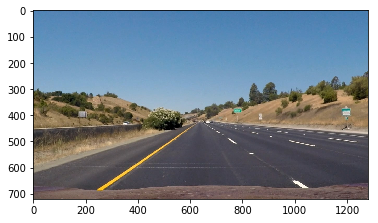

In [4]:
test = cv2.imread('test_images/straight_lines1.jpg')
test1 = cv2.cvtColor(test,cv2.COLOR_BGR2RGB)
plt.imshow(test1)

In [5]:
#undistorting images
def undistort(image,mtx,dist):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    undist = cv2.undistort(image,mtx,dist,None,mtx)
    return undist

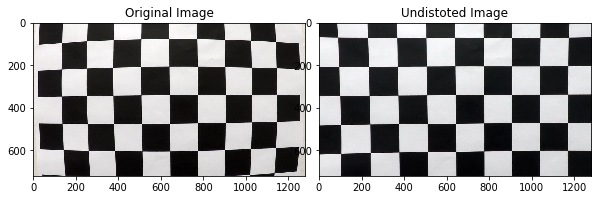

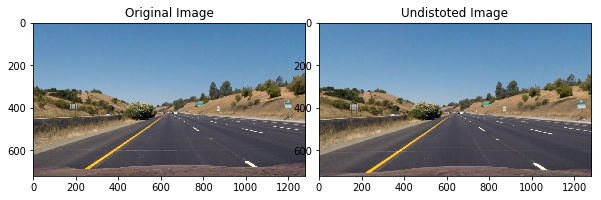

In [6]:
chess_board = cv2.imread('examples/camera_cal/calibration1.jpg')
chess_board = cv2.cvtColor(chess_board,cv2.COLOR_BGR2RGB)

fig_i,axs_i = plt.subplots(1,2,figsize=(10,20))
fig_i.subplots_adjust(wspace=.05)
axs_i = axs_i.ravel()
axs_i[0].imshow(chess_board)
axs_i[0].set_title("Original Image")
undist = undistort(chess_board,mtx,dist)
axs_i[1].set_title("Undistoted Image")
axs_i[1].imshow(undist)


#undistortion of image
fig,axs = plt.subplots(1,2,figsize=(10,20))
fig.subplots_adjust(wspace=.05)
axs = axs.ravel()
axs[0].imshow(test1)
axs[0].set_title("Original Image")
undist = undistort(test,mtx,dist)
axs[1].set_title("Undistoted Image")
axs[1].imshow(undist)

In [7]:
#thresholding
def thresholding(image,threshold=(220,255)):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel*(255/np.max(l_channel))
    
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > threshold[0])&(l_channel <= threshold[1])] = 1
    return binary_output

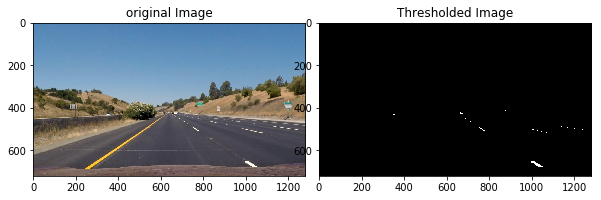

In [8]:
fig_thres,axs_thres = plt.subplots(1,2,figsize=(10,20))
plt.subplots_adjust(hspace=0.001,wspace = 0.05)
axs_thres = axs_thres.ravel()

axs_thres[0].set_title("original Image")
axs_thres[0].imshow(test1)
binary_output = thresholding(test)
axs_thres[1].set_title("Thresholded Image")
axs_thres[1].imshow(binary_output,cmap='gray')


In [9]:
#color_thresholding
def color_thresholding(image,threshold=(190,255)):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    color = cv2.cvtColor(image,cv2.COLOR_RGB2Lab)
    c = color[:,:,2]
    color_output = np.zeros_like(c)
    if np.max(c)>175:
        c = c*(255/np.max(c))
    color_output[((c > threshold[0]) & (c <= threshold[1]))] = 1
    return color_output

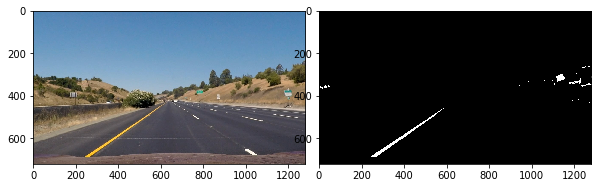

In [10]:
fig_c,axs_c = plt.subplots(1,2,figsize=(10,20))
plt.subplots_adjust(hspace=0.001,wspace=0.05)
axs_c = axs_c.ravel()

color_binary = color_thresholding(test)
axs_c[0].imshow(test1)
axs_c[1].imshow(color_binary,cmap='gray')

In [11]:
#perpective_transform
def prespective_transform(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    h,w = image.shape[:2]
    src = np.float32([(580,460),
                  (710,460), 
                  (150,720), 
                  (1150,720)])
    dst = np.float32([(450,0),
                  (830,0),
                  (450,h),
                  (860,h)])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    p_warp = cv2.warpPerspective(image,M,(w,h),flags=cv2.INTER_LINEAR)
    return p_warp, M, Minv
    
    

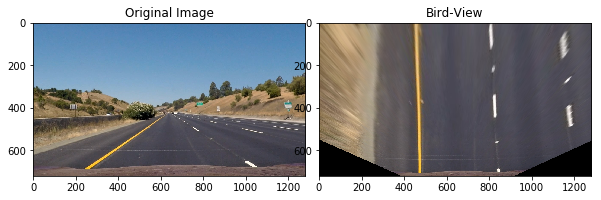

In [12]:
fig_transform,axs_transform = plt.subplots(1,2,figsize=(10,20))
plt.subplots_adjust(hspace=0.001,wspace=0.05)
axs_transform = axs_transform.ravel()
axs_transform[0].set_title("Original Image")
axs_transform[0].imshow(test1)
p_warp,M,Minv = prespective_transform(test)
axs_transform[1].set_title("Bird-View")
axs_transform[1].imshow(p_warp)
    

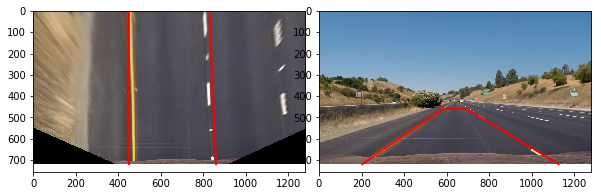

In [13]:
area_of_interest_src = [[585,460],[695,460],[1127,720],[203,720]]
x_values = [area_of_interest_src[3][0],area_of_interest_src[0][0],area_of_interest_src[1][0],area_of_interest_src[2][0]]
y_values = [area_of_interest_src[3][1],area_of_interest_src[0][1],area_of_interest_src[1][1],area_of_interest_src[2][1]]

area_of_interest_dst = [[450,720],[450,0],[830,0],[860,720]]
x = [area_of_interest_dst[0][0],area_of_interest_dst[1][0],area_of_interest_dst[2][0],area_of_interest_dst[3][0]]
y = [area_of_interest_dst[0][1],area_of_interest_dst[1][1],area_of_interest_dst[2][1],area_of_interest_dst[3][1]]



fig_plot,axs_plot = plt.subplots(1,2,figsize=(10,20))
plt.subplots_adjust(wspace=0.05)
axs_plot = axs_plot.ravel()
axs_plot[0].imshow(p_warp)
axs_plot[0].plot(x,y,'r-',lw=2)

axs_plot[1].imshow(test1)
axs_plot[1].plot(x_values,y_values,'r-',lw=2)

In [14]:
#pipeline
def pipeline(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    undist = undistort(image,mtx,dist)
    p_view,M,Minv = prespective_transform(undist)
    binary_output = thresholding(p_view)
    color_binary = color_thresholding(p_view)
    combined_image = np.zeros_like(color_binary)
    combined_image[(binary_output == 1)|(color_binary == 1)] = 1
    return combined_image, Minv

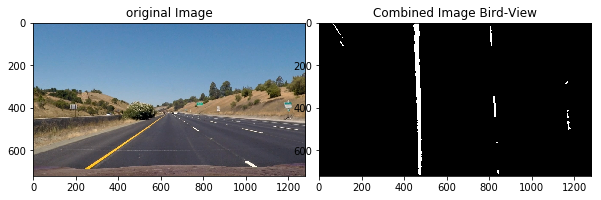

In [15]:
fig_p,axs_p = plt.subplots(1,2,figsize=(10,20))
plt.subplots_adjust(hspace=0.001,wspace=0.05)
axs_p = axs_p.ravel()

axs_p[0].set_title("original Image")
axs_p[0].imshow(test1)

combined,Minv = pipeline(test1)
axs_p[1].set_title("Combined Image Bird-View")
axs_p[1].imshow(combined,cmap="gray")

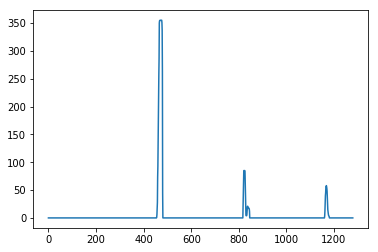

In [16]:
#ploting histogram of images
import numpy as np
histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [17]:
#finding lane lines
def finding_lane_line(image):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    out_img = np.dstack((combined,combined,combined))*255
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        #plt.imshow(out_img)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit,left_lane_inds,right_lane_inds,out_img

(720, 0)

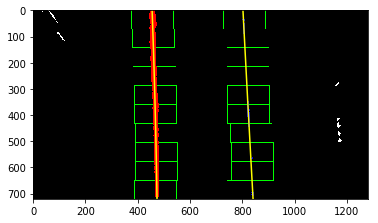

In [18]:
#fig_lane,axs_lane = plt.subplots(1,2,figsize=(10,20))
#plt.subplots_adjust(hspace=0.002,wspace=0.05)
#axs_lane = axs_lane.ravel()
combined_image,Minv = pipeline(test1)
left_fit,right_fit,left_lane_inds,right_lane_inds,out_img = finding_lane_line(combined_image)

ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]



nonzero = combined.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)




In [19]:
#sliding window search
def sliding_window_search(binary_warped,left_fit,right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx,right_fitx,left_lane_inds,right_lane_inds

(720, 0)

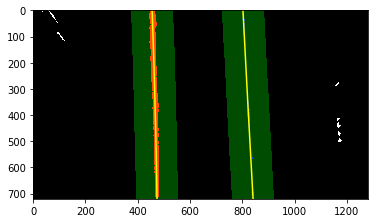

In [20]:
# Create an image to draw on and an image to show the selection window
binary_warped,Minv = pipeline(test1)
margin = 80
left_fitx, right_fitx,left_lane_inds,right_lane_inds = sliding_window_search(binary_warped,left_fit,right_fit)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right lane line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [21]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def radius_curvature(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    ym_per_pix = 3.048/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/378 # meters per pixel in x dimension
    
    #left_curvature, right curvature, center curvature measurements
    left_curverad, right_curverad, center_dist = (0, 0, 0)
   
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    #identifying the lane lines from the array
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
 
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    #checking whether the left and right fit are empty
    if len(leftx) != 0 and len(rightx) != 0:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the radius of curvature using the equation
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    
    #find the center car postion 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        
    return left_curverad, right_curverad, center_dist
print('...')

...


In [22]:
#radius of curvature of image
left_radius,right_radius,center_radius = radius_curvature(binary_warped,left_fit,right_fit,left_lane_inds,right_lane_inds)

print('Radius of curvature of this particular Image:','Left_Radius:',left_radius, 'm,','Right_Radius:', right_radius, 'm')
print('Distance from lane center:',center_radius, 'm')

Radius of curvature of this particular Image: Left_Radius: 3156.91850719 m, Right_Radius: 13634.8109189 m
Distance from lane center: -0.170612610364 m


In [23]:
def draw(original_img, binary_ouput, left_fit, right_fit, Minv):
    new_img = np.copy(original_img)
    if left_fit is None or right_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_output).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_output.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.3, 0)
    return result
print('...')

...


(-0.5, 1279.5, 719.5, -0.5)

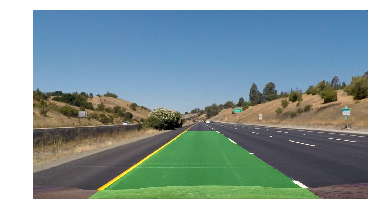

In [24]:
result = draw(test1,binary_warped,left_fit,right_fit,Minv)
plt.imshow(result)
plt.axis('off')


In [25]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


...


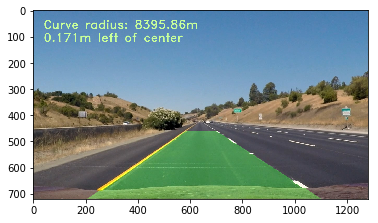

In [26]:
image = draw_data(result, (left_radius+right_radius)/2, center_radius)
plt.imshow(image)
print('...')

In [27]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            

print('...')

...


In [28]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
   #check whether line detected,if detected use sliding window() else findind_lane_line()
    if not l_line.detected or not r_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds,out_img = finding_lane_line(img_bin)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_search(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(right_fit_x_int-left_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            left_fit = None
            right_fit = None
            
    l_line.add_fit(left_fit, left_lane_inds)
    r_line.add_fit(right_fit, right_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = radius_curvature(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               left_lane_inds, right_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    return img_out
print('...')

...


In [29]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:09<00:00,  4.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 13s
